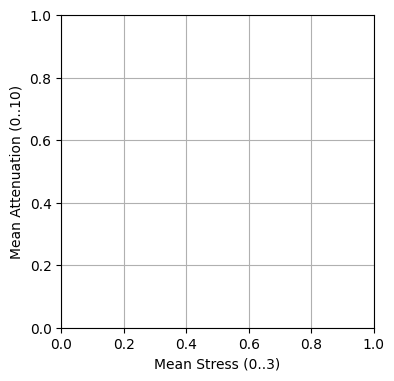

In [ ]:
#!/usr/bin/env python3
import os
import re
import cv2
import numpy as np
import scipy.io as sio
import tkinter as tk
from tkinter import ttk, filedialog
from PIL import Image, ImageTk
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import mplcursors
import glob
from tracking_algorithms import TrackingAlgorithms

# ------------------------------- helpers --------------------------------------
def _natural_key(s: str):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]

def compose_flows(fwd_0_to_kminus1, fwd_kminus1_to_k):
    """Compose optical flows: flow(0->k) = flow(0->k-1) ∘ flow(k-1->k)."""
    H, W = fwd_0_to_kminus1.shape[:2]
    xs = np.arange(W, dtype=np.float32)
    ys = np.arange(H, dtype=np.float32)
    grid_x = xs[None, :].repeat(H, axis=0)
    grid_y = ys[:, None].repeat(W, axis=1)
    map_x = grid_x + fwd_0_to_kminus1[..., 0]
    map_y = grid_y + fwd_0_to_kminus1[..., 1]
    warped_inc = np.zeros_like(fwd_kminus1_to_k)
    for c in range(2):
        warped_inc[..., c] = cv2.remap(
            fwd_kminus1_to_k[..., c], map_x, map_y,
            interpolation=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_CONSTANT, borderValue=0
        )
    return fwd_0_to_kminus1 + warped_inc

# ------------------------------ main widget -----------------------------------
class StressAttenuationExplorer(ttk.Frame):
    """
    Layout:
      - Left: slim tools column (controls + square scatter that matches tools column height)
      - Right: two big canvases side-by-side (focus on imagery)

    Overlays:
      - Raw Att (viridis 0..10), Raw Str (jet 0..3)
      - ΔAtt (current - original), ΔStr (current - original)
      - ΔAtt/ΔStr ratio
    All overlays are clipped to the valid extent of the warped OCT geometry.
    """
    def __init__(self, parent, **kwargs):
        super().__init__(parent, **kwargs)

        # ── Root layout using PanedWindow for better resizing
        root_panes = ttk.Panedwindow(self, orient='horizontal')
        root_panes.pack(fill='both', expand=True)

        # Left (tools)
        tools_frame = ttk.Frame(root_panes, padding=(8,8))
        root_panes.add(tools_frame, weight=0)  # slim
        self.tools_frame = tools_frame

        # Right (views)
        views_frame = ttk.Frame(root_panes)
        root_panes.add(views_frame, weight=1)

        # ── Top controls (in tools)
        ctrl_top = ttk.Frame(tools_frame)
        ctrl_top.pack(fill='x', pady=(0,8))
        ttk.Button(ctrl_top, text="Select Sequence Folder", command=self._select_sequence_root)\
            .pack(side='left')
        self.seq_label = ttk.Label(ctrl_top, text="No folder", width=24)
        self.seq_label.pack(side='left', padx=8)

        # Options
        opt = ttk.Labelframe(tools_frame, text="Display", padding=6)
        opt.pack(fill='x', pady=6)
        self.show_original_var = tk.BooleanVar(value=False)
        self.show_unwarped_var = tk.BooleanVar(value=False)
        ttk.Checkbutton(opt, text="Compare with Original (frame 0)",
                        variable=self.show_original_var,
                        command=self._refresh_display).pack(anchor='w')
        ttk.Checkbutton(opt, text="Compare with Unwarped Current",
                        variable=self.show_unwarped_var,
                        command=self._refresh_display).pack(anchor='w')

        # Overlays
        overlays = ttk.Labelframe(tools_frame, text="Overlays", padding=6)
        overlays.pack(fill='x', pady=6)
        self.overlay_att_var   = tk.BooleanVar(value=False)
        self.overlay_str_var   = tk.BooleanVar(value=False)
        self.overlay_datt_var  = tk.BooleanVar(value=False)   # NEW: ΔAtt
        self.overlay_dstr_var  = tk.BooleanVar(value=False)   # NEW: ΔStr
        self.overlay_resp_var  = tk.BooleanVar(value=True)    # ΔAtt/ΔStr default ON
        self.show_headtail_var = tk.BooleanVar(value=False)
        self.show_net_var      = tk.BooleanVar(value=False)
        self.sensitivity = tk.DoubleVar(value=1.0)

        ttk.Checkbutton(overlays, text="Attenuation (viridis 0..10)",
                        variable=self.overlay_att_var,
                        command=self._on_overlay_toggle).pack(anchor='w')
        ttk.Checkbutton(overlays, text="Stress (jet 0..3)",
                        variable=self.overlay_str_var,
                        command=self._on_overlay_toggle).pack(anchor='w')
        ttk.Checkbutton(overlays, text="ΔAtt (current − original)",
                        variable=self.overlay_datt_var,
                        command=self._on_overlay_toggle).pack(anchor='w')
        ttk.Checkbutton(overlays, text="ΔStr (current − original)",
                        variable=self.overlay_dstr_var,
                        command=self._on_overlay_toggle).pack(anchor='w')
        ttk.Checkbutton(overlays, text="ΔAtt/ΔStr (ratio)",
                        variable=self.overlay_resp_var,
                        command=self._on_overlay_toggle).pack(anchor='w')
        ttk.Separator(overlays, orient='horizontal').pack(fill='x', pady=6)
        ttk.Checkbutton(overlays, text="Head–Tail Trajectories",
                        variable=self.show_headtail_var,
                        command=self._refresh_display).pack(anchor='w')
        ttk.Checkbutton(overlays, text="Net Vectors",
                        variable=self.show_net_var,
                        command=self._refresh_display).pack(anchor='w')
        
        # Add after the overlay checkbuttons, before the separator
        sensitivity_frame = ttk.Frame(overlays)
        sensitivity_frame.pack(fill='x', pady=4)
        ttk.Label(sensitivity_frame, text="Sensitivity: Low").pack(side='left')
        sensitivity_slider = ttk.Scale(
            sensitivity_frame, 
            from_=0.1, to=10.0,
            variable=self.sensitivity,
            orient='horizontal',
            command=lambda _: self._refresh_display()
        )
        sensitivity_slider.pack(side='left', fill='x', expand=True, padx=4)
        ttk.Label(sensitivity_frame, text="High").pack(side='left')

        # Navigation + actions
        nav = ttk.Frame(tools_frame)
        nav.pack(fill='x', pady=8)
        ttk.Button(nav, text="<< Prev", command=lambda: self._advance(-1)).pack(side='left')
        ttk.Button(nav, text="Next >>", command=lambda: self._advance(1)).pack(side='left', padx=6)
        self.index_label = ttk.Label(nav, text="Frame: N/A")
        self.index_label.pack(side='left', padx=8)
        ttk.Button(nav, text="Toggle Compare (Orig ⇄ Warped)", command=self._toggle_compare).pack(side='left', padx=6)
        ttk.Button(nav, text="Clear Box", command=self._clear_box).pack(side='left', padx=6)

        # Scatter graph (square, matches tools column height)
        graph_box = ttk.Labelframe(tools_frame, text="Mean Stress vs Mean Atten", padding=6)
        graph_box.pack(fill='both', expand=True, pady=(4,0))
        self.fig, self.ax = plt.subplots(figsize=(4,4))
        self.ax.set_aspect('equal', adjustable='box')
        self.scatter_canvas = FigureCanvasTkAgg(self.fig, master=graph_box)
        self.scatter_widget = self.scatter_canvas.get_tk_widget()
        self.scatter_widget.pack(fill='both', expand=True)
        self.ax.set_xlabel("Mean Stress (0..3)")
        self.ax.set_ylabel("Mean Attenuation (0..10)")
        self.ax.grid(True)

        # Bind tools column resize to keep the graph square & match height
        tools_frame.bind("<Configure>", self._on_tools_resize)

        # ── Right: two canvases side-by-side (focus)
        right_top = ttk.Frame(views_frame)
        right_top.pack(fill='both', expand=True, padx=8, pady=8)

        left_area  = ttk.Frame(right_top)
        right_area = ttk.Frame(right_top)
        left_area.pack(side='left', fill='both', expand=True, padx=(0,4))
        right_area.pack(side='left', fill='both', expand=True, padx=(4,0))

        ttk.Label(left_area, text="Compare: Original vs Warped-to-Frame0").pack(anchor='w')
        self.canvas_left = tk.Canvas(left_area, bg="#000", highlightthickness=0)
        self.canvas_left.pack(fill='both', expand=True, pady=(2,0))
        self.canvas_left.bind("<ButtonPress-1>", self._on_box_start)
        self.canvas_left.bind("<B1-Motion>", self._on_box_drag)
        self.canvas_left.bind("<ButtonRelease-1>", self._on_box_end)

        ttk.Label(right_area, text="Overlay View (Δ/ratio or selected)").pack(anchor='w')
        self.canvas_right = tk.Canvas(right_area, bg="#000", highlightthickness=0)
        self.canvas_right.pack(fill='both', expand=True, pady=(2,0))
        self.canvas_right.bind("<ButtonPress-1>", self._on_box_start)
        self.canvas_right.bind("<B1-Motion>", self._on_box_drag)
        self.canvas_right.bind("<ButtonRelease-1>", self._on_box_end)

        # ── State
        self.sequence_root = None
        self.images = {"oct": [], "stress": [], "att": []}   # RGB/gray originals
        self.scalar_images = {"stress": [], "att": []}       # precomputed scalars (unwarped)
        self.current_idx = 0
        self.cumulative = {"shared_flow": {}}
        self.incremental_flows = {}
        self.quiver_step = 20
        self.trajectory_s = []; self.trajectory_a = []
        self.box_start = None; self.box_end = None
        self._cursor = None
        self.compare_show = 'warped'  # 'orig' or 'warped'
        self._active_canvas = None

        # Fixed overlay opacities (0..1)
        self._alpha_att   = 0.5
        self._alpha_str   = 0.5
        self._alpha_resp  = 0.5  # ratio
        self._alpha_delta = 0.5  # Δ overlays

        # ---- Build reverse LUTs once ----
        self._lut_viridis = self._build_rgb24_scalar_lut('viridis', 0.0, 10.0)
        self._lut_jet     = self._build_rgb24_scalar_lut('jet',     0.0,  3.0)

        viridis = matplotlib.colormaps['viridis'].resampled(256)
        jet     = matplotlib.colormaps['jet'].resampled(256)
        self._viridis_table_rgb = viridis(np.arange(256))[:, :3].astype(np.float32)
        self._viridis_vals      = np.linspace(0.0, 10.0, 256, dtype=np.float32)
        self._jet_table_rgb     = jet(np.arange(256))[:, :3].astype(np.float32)
        self._jet_vals          = np.linspace(0.0,  3.0, 256, dtype=np.float32)

    # ------------------------ reverse mapping ----------------------------------
    @staticmethod
    def _build_rgb24_scalar_lut(cmap_name: str, data_min: float, data_max: float):
        lut = np.full(256**3, np.nan, dtype=np.float32)
        cmap = matplotlib.colormaps[cmap_name].resampled(256)
        rgbf = cmap(np.arange(256))[:, :3]
        rgb = (np.clip(rgbf, 0, 1) * 255.0 + 0.5).astype(np.uint8)
        vals = np.linspace(data_min, data_max, 256, dtype=np.float32)
        codes = (rgb[:,0].astype(np.uint32) << 16) | (rgb[:,1].astype(np.uint32) << 8) | rgb[:,2].astype(np.uint32)
        lut[codes] = vals
        return lut

    @staticmethod
    def _rgb_to_code(img_uint8):
        return (img_uint8[...,0].astype(np.uint32) << 16) | \
               (img_uint8[...,1].astype(np.uint32) << 8)  | \
                img_uint8[...,2].astype(np.uint32)

    def _reverse_map_hybrid(self, rgb_img, lut_24bit, table_rgb, table_vals):
        if rgb_img is None:
            return None
        if rgb_img.ndim == 2 or (rgb_img.ndim == 3 and rgb_img.shape[2] == 1):
            return rgb_img.astype(np.float32).squeeze()
        img = rgb_img
        if img.ndim == 3 and img.shape[2] == 4:
            try:
                img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
            except Exception:
                img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        elif img.ndim == 3 and img.shape[2] == 3:
            pass
        else:
            img = img[..., :3]
        if img.dtype != np.uint8:
            img = np.clip(img, 0, 255).astype(np.uint8)
        codes = self._rgb_to_code(img).ravel()
        scalars = lut_24bit[codes].astype(np.float32)
        missing = np.isnan(scalars)
        if missing.any():
            pix = img.reshape(-1, 3)[missing].astype(np.float32) / 255.0
            a2 = np.sum(pix**2, axis=1, keepdims=True)
            b2 = np.sum(table_rgb**2, axis=1, keepdims=True).T
            ab = pix @ table_rgb.T
            d2 = a2 + b2 - 2.0 * ab
            idx = np.argmin(d2, axis=1)
            scalars[missing] = table_vals[idx].astype(np.float32)
        return scalars.reshape(img.shape[:2])

    # ------------------------------- UI helpers --------------------------------
    def _on_overlay_toggle(self):
        self._refresh_display()

    def _safe_get(self, seq, idx):
        return seq[idx] if 0 <= idx < len(seq) else None

    # ------------------------------- data I/O ----------------------------------
    def _show_loading(self, message="Loading..."):
        top = tk.Toplevel(self)
        top.title("Please wait")
        top.transient(self.winfo_toplevel())
        top.grab_set()
        top.resizable(False, False)
        ttk.Label(top, text=message).pack(padx=16, pady=(16,8))
        pb = ttk.Progressbar(top, mode='indeterminate', length=220)
        pb.pack(padx=16, pady=(0,16))
        pb.start(10)
        self.update_idletasks()
        # center over parent
        self.update_idletasks()
        px = self.winfo_rootx() + self.winfo_width()//2 - top.winfo_reqwidth()//2
        py = self.winfo_rooty() + self.winfo_height()//2 - top.winfo_reqheight()//2
        top.geometry(f"+{px}+{py}")
        return top, pb

    def _select_sequence_root(self):
        folder = filedialog.askdirectory()
        if not folder:
            return
        loading, _ = self._show_loading("Loading sequence folders (oct/str/att)...")
        try:
            self.sequence_root = folder
            self.seq_label.config(text=os.path.basename(folder))
            self._load_modalities()
            self.current_idx = 0
            self.cumulative = {"shared_flow": {}}
            self.incremental_flows = {}
            self.trajectory_s = []; self.trajectory_a = []
            self.box_start = None; self.box_end = None
        finally:
            loading.destroy()
        self._refresh_display()

    def _load_modalities(self):
        """Load OCT, Stress and Attenuation data from .mat files"""
        
        # Clear existing data
        self.images = {"oct": [], "stress": [], "att": []}
        self.scalar_images = {"stress": [], "att": []}
        
        # Get list of .mat files in sequence root
        oct_files = glob.glob(os.path.join(self.sequence_root, "*OCT*.mat"))
        stress_files = glob.glob(os.path.join(self.sequence_root, "*Stress*.mat"))
        att_files = glob.glob(os.path.join(self.sequence_root, "*Attenuation*.mat"))
        
        if not oct_files or not stress_files or not att_files:
            print("Missing required .mat files")
            return
            
        # Load arrays
        try:
            oct_data = sio.loadmat(oct_files[0])
            stress_data = sio.loadmat(stress_files[0])
            att_data = sio.loadmat(att_files[0])
            
            # Find arrays with correct shape (364x364xN)
            oct_array = None
            stress_array = None
            att_array = None
            
            for key, value in oct_data.items():
                if key.startswith('__'): continue  # Skip metadata
                if isinstance(value, np.ndarray) and len(value.shape) == 3 and value.shape[:2] == (364, 364):
                    oct_array = value
                    break
                    
            for key, value in stress_data.items():
                if key.startswith('__'): continue
                if isinstance(value, np.ndarray) and len(value.shape) == 3 and value.shape[:2] == (364, 364):
                    stress_array = value
                    break
                    
            for key, value in att_data.items():
                if key.startswith('__'): continue
                if isinstance(value, np.ndarray) and len(value.shape) == 3 and value.shape[:2] == (364, 364):
                    att_array = value
                    break
            
            if oct_array is None or stress_array is None or att_array is None:
                print("Could not find valid arrays in .mat files")
                return
                
            # Convert arrays to list of 2D images
            num_frames = oct_array.shape[2]
            
            # OCT images - normalize to 0-255 uint8
            for i in range(num_frames):
                slice_data = oct_array[:,:,i]
                # Normalize to 0-29 range
                normalized = np.clip(slice_data, 0, 29)  # Ensure values are in range
                # Convert to 0-255 for display
                normalized = ((normalized / 29.0) * 255).astype(np.uint8)
                self.images["oct"].append(normalized)
            
            for i in range(num_frames):
                slice_data = stress_array[:,:,i]
                # Convert negative kPa to positive log10 values
                # Add small epsilon to avoid log(0)
                eps = 1e-6
                log_stress = np.log10(-slice_data + eps)  # Negative since input is negative
                self.scalar_images["stress"].append(log_stress)
                # Convert to RGB visualization using jet colormap for log10 values 0-2
                rgb = self._apply_colormap(log_stress, 'jet', 0, 2)
                self.images["stress"].append(rgb)
                
            # Attenuation images - store both RGB visualization and scalar data  
            for i in range(num_frames):
                slice_data = att_array[:,:,i]
                # Clamp attenuation values to 0-10 range
                slice_data = np.clip(slice_data, 0, 10)
                self.scalar_images["att"].append(slice_data)
                # Convert to RGB visualization using viridis colormap
                rgb = self._apply_colormap(slice_data, 'viridis', 0, 10)
                self.images["att"].append(rgb)

            total = len(self.images["oct"])
            self.index_label.config(text=f"Frame: {self.current_idx+1}/{total}")
            
        except Exception as e:
            print(f"Error loading .mat files: {e}")
            return

    def _apply_colormap(self, data, cmap_name, vmin, vmax):
        """Convert scalar data to RGB using matplotlib colormap"""
        # Handle NaN values
        valid_data = np.nan_to_num(data, nan=vmin)
        # Normalize to 0-1 range
        norm = (np.clip(valid_data, vmin, vmax) - vmin) / (vmax - vmin)
        # Apply colormap
        cmap = matplotlib.colormaps[cmap_name]
        rgb = cmap(norm)[..., :3]
        return (rgb * 255).astype(np.uint8)

    def _advance(self, delta):
        if not self.images["oct"]:
            return
        self.current_idx = int(np.clip(self.current_idx + delta, 0, len(self.images["oct"]) - 1))
        self.index_label.config(text=f"Frame: {self.current_idx+1}/{len(self.images['oct'])}")
        self._refresh_display()

    # ------------------------------ optical flow --------------------------------
    def _to_gray(self, img):
        if img is None: return None
        if img.ndim == 2: return img
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    def _compute_incremental_flow(self, prev, curr):
        # Use selected algorithm from dropdown
        alg_name = self.selected_algorithm.get()
        prev_gray = prev if prev.ndim == 2 else cv2.cvtColor(prev, cv2.COLOR_RGB2GRAY)
        curr_gray = curr if curr.ndim == 2 else cv2.cvtColor(curr, cv2.COLOR_RGB2GRAY)
        flow = self.tracking.run(alg_name, prev_gray, curr_gray)
        return flow

    def _get_cumulative_flow(self, index):
        if index in self.cumulative["shared_flow"]:
            return self.cumulative["shared_flow"][index]
        if not self.images["oct"] or index >= len(self.images["oct"]):
            return None
        ref = self._to_gray(self.images["oct"][0])
        cumulative_flow = np.zeros((*ref.shape, 2), dtype=np.float32)
        prev = ref
        for idx in range(1, index + 1):
            curr = self._to_gray(self.images["oct"][idx])
            flow_inc = self._compute_incremental_flow(prev, curr)
            self.incremental_flows[idx] = flow_inc
            cumulative_flow = flow_inc.copy() if idx == 1 else compose_flows(cumulative_flow, flow_inc)
            prev = curr
        self.cumulative["shared_flow"][index] = cumulative_flow
        return cumulative_flow

    def _warp_with_shared_flow(self, arr, index):
        """Warp array (RGB or single-channel) defined in frame 'index' to frame-0 geometry."""
        if arr is None:
            return None, None
        flow = self._get_cumulative_flow(index)
        if flow is None:
            return None, None
        H, W = flow.shape[:2]
        xs = np.arange(W, dtype=np.float32); ys = np.arange(H, dtype=np.float32)
        map_x = xs[None, :] + flow[..., 0]
        map_y = ys[:, None] + flow[..., 1]
        if arr.ndim == 2:
            warped = cv2.remap(arr, map_x, map_y, interpolation=cv2.INTER_LINEAR,
                               borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        else:
            warped = np.zeros_like(arr)
            for ch in range(arr.shape[2]):
                warped[..., ch] = cv2.remap(arr[..., ch], map_x, map_y,
                                            interpolation=cv2.INTER_LINEAR,
                                            borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        valid_mask = (map_x >= 0)&(map_x<=W-1)&(map_y>=0)&(map_y<=H-1)
        return warped, valid_mask

    # ------------------------------ RGB utils & blending ------------------------
    @staticmethod
    def _to_rgb(img):
        if img is None: return None
        if img.ndim == 2 or (img.ndim == 3 and img.shape[2] == 1):
            g = img.astype(np.uint8)
            if g.ndim == 3: g = g[..., 0]
            return cv2.cvtColor(g, cv2.COLOR_GRAY2RGB)
        if img.ndim == 3 and img.shape[2] == 3:
            return img.astype(np.uint8)
        if img.ndim == 3 and img.shape[2] == 4:
            arr = img.astype(np.uint8)
            try:
                return cv2.cvtColor(arr, cv2.COLOR_RGBA2RGB)
            except Exception:
                return cv2.cvtColor(arr, cv2.COLOR_BGRA2RGB)
        return img[..., :3].astype(np.uint8)

    @staticmethod
    def _alpha_blend(base_rgb, over_rgb, alpha):
        base_rgb = StressAttenuationExplorer._to_rgb(base_rgb)
        over_rgb = StressAttenuationExplorer._to_rgb(over_rgb)
        if base_rgb is None or over_rgb is None:
            return base_rgb if base_rgb is not None else over_rgb
        if over_rgb.shape[:2] != base_rgb.shape[:2]:
            over_rgb = cv2.resize(over_rgb, (base_rgb.shape[1], base_rgb.shape[0]), interpolation=cv2.INTER_LINEAR)
        bf = base_rgb.astype(np.float32); of = over_rgb.astype(np.float32)
        out = (1.0 - alpha) * bf + alpha * of
        return np.clip(out, 0, 255).astype(np.uint8)

    def _alpha_blend_masked(self, base_rgb, over_rgb, alpha, mask):
        base_rgb = self._to_rgb(base_rgb)
        over_rgb = self._to_rgb(over_rgb)
        if base_rgb is None or over_rgb is None:
            return base_rgb if base_rgb is not None else over_rgb
        if over_rgb.shape[:2] != base_rgb.shape[:2]:
            over_rgb = cv2.resize(over_rgb, (base_rgb.shape[1], base_rgb.shape[0]), interpolation=cv2.INTER_LINEAR)
        out = base_rgb.copy()
        if mask is None:
            bf = base_rgb.astype(np.float32); of = over_rgb.astype(np.float32)
            out = np.clip((1.0 - alpha) * bf + alpha * of, 0, 255).astype(np.uint8)
            return out
        m = mask.astype(bool)
        if not np.any(m):
            return out
        bf = base_rgb[m].astype(np.float32)
        of = over_rgb[m].astype(np.float32)
        out[m] = np.clip((1.0 - alpha) * bf + alpha * of, 0, 255).astype(np.uint8)
        return out

    # ------------------------------ render & metrics ----------------------------
    def _refresh_display(self):
        if not self.sequence_root or not self.images["oct"]:
            return

        # get the number of frames available
        total = len(self.images["oct"])
        self.index_label.config(text=f"Frame: {self.current_idx+1}/{total}")

        # the raw oct image at frame 0
        base_oct_raw0 = self._safe_get(self.images["oct"], 0)
        # the raw oct image at current frame
        cur_oct_raw   = self._safe_get(self.images["oct"], self.current_idx)

        # Helper: convert to gray float32, None -> zeros like base_oct_raw0
        def to_gray(img):
            # None images handled as zeros for overlays
            if img is None:
                if base_oct_raw0 is None: return None
                ref = base_oct_raw0 if base_oct_raw0.ndim == 2 else cv2.cvtColor(base_oct_raw0, cv2.COLOR_RGB2GRAY)
                return np.zeros_like(ref, dtype=np.float32)
            if img.ndim == 2: return img.astype(np.float32)
            # convert rgb to gray image
            return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float32)

        # ---------- LEFT CANVAS: Compare ----------
        left_orig_gray = to_gray(base_oct_raw0)  # frame 0
        left_unwarp_gray = to_gray(cur_oct_raw)  # current frame unwarped
        warped_oct, mask_oct = self._warp_with_shared_flow(cur_oct_raw, self.current_idx)
        left_warp_gray = to_gray(warped_oct if warped_oct is not None else cur_oct_raw)

        if left_warp_gray is not None and mask_oct is not None:
            # Mask out invalid regions in warped image
            lw = left_warp_gray.copy()
            lw[~mask_oct] = 0
            left_warp_gray = lw

        # Choose what to display based on checkboxes
        if self.show_original_var.get():
            # Compare warped with original frame 0
            left_rgb = self._to_rgb(left_orig_gray)
        elif self.show_unwarped_var.get():
            # Compare warped with unwarped current frame
            left_rgb = self._to_rgb(left_unwarp_gray)
        else:
            # Show warped by default
            left_rgb = self._to_rgb(left_warp_gray)

        # draw the vectors of the deformation field over the image. optionally show head-tail vectors 
        cumulative_flow = self._get_cumulative_flow(self.current_idx)
        self._draw_on_canvas(self.canvas_left, left_rgb, cumulative_flow,
                             show_headtail=self.show_headtail_var.get(),
                             valid_mask=None)

        # ---------- RIGHT CANVAS: Overlay view ----------
        base_gray = left_warp_gray if left_warp_gray is not None else to_gray(cur_oct_raw)
        if base_gray is None:
            return
        display_rgb = self._to_rgb(base_gray)

        # Overlays (fixed alpha) - strictly mask to warped OCT geometry
        cur_str = self._safe_get(self.images["stress"], self.current_idx)
        cur_att = self._safe_get(self.images["att"],    self.current_idx)
        warped_str_rgb, _ = self._warp_with_shared_flow(cur_str, self.current_idx) if cur_str is not None else (None, None)
        warped_att_rgb, _ = self._warp_with_shared_flow(cur_att, self.current_idx) if cur_att is not None else (None, None)

        geom_mask = mask_oct  # available extent is where the warped OCT is valid
        if self.overlay_att_var.get() and warped_att_rgb is not None:
            display_rgb = self._alpha_blend_masked(display_rgb, warped_att_rgb, self._alpha_att, geom_mask)
        if self.overlay_str_var.get() and warped_str_rgb is not None:
            display_rgb = self._alpha_blend_masked(display_rgb, warped_str_rgb, self._alpha_str, geom_mask)

        # --- Preload scalar maps for Δ and ratio ---
        a_ref = self._safe_get(self.scalar_images["att"], 0)
        s_ref = self._safe_get(self.scalar_images["stress"], 0)
        a_cur = self._safe_get(self.scalar_images["att"], self.current_idx) if self.current_idx >= 1 else None
        s_cur = self._safe_get(self.scalar_images["stress"], self.current_idx) if self.current_idx >= 1 else None

        # Helper: robust symmetric color scaling
        def _sym_cmap_image(delta_arr, valid_mask_final, cmap_name='viridis'):
            """
            Create an RGB visualization of change magnitude.
            Areas of minimal change will be dark/black, larger changes will be brighter.
            """
            finite = np.isfinite(delta_arr) & valid_mask_final
            if not np.any(finite):
                return None
            
            # Take absolute value - we only care about magnitude of change
            abs_delta = np.abs(delta_arr)
            
            # Find robust min/max of the absolute values
            vals = abs_delta[finite]
            vmin = float(np.nanpercentile(vals, 2.0))  # ignore extreme outliers
            vmax = float(np.nanpercentile(vals, 98.0))
            
            if not np.isfinite(vmin) or not np.isfinite(vmax) or vmax <= vmin:
                vmin, vmax = 0.0, float(np.nanmax(vals)) if np.any(np.isfinite(vals)) else 1.0
            
            # Normalize to [0,1] - small changes will be closer to 0
            norm = np.clip((abs_delta - vmin) / (vmax - vmin + 1e-12), 0.0, 1.0)
            
            # Apply colormap - using viridis by default:
            # - Dark purple/black = minimal change
            # - Yellow = maximum change
            cmap = matplotlib.colormaps[cmap_name]
            rgb = (cmap(norm)[..., :3] * 255.0 + 0.5).astype(np.uint8)
            rgb[~valid_mask_final] = 0
            
            return rgb

        # ΔAtt overlay
        if self.overlay_datt_var.get() and self.current_idx >= 1 and all(v is not None for v in (a_ref, a_cur)):
            a_ref_w, mask_a_ref = self._warp_with_shared_flow(a_ref, 0)
            a_cur_w, mask_a_cur = self._warp_with_shared_flow(a_cur, self.current_idx)
            if a_ref_w is not None and a_cur_w is not None:
                d_att = (a_cur_w - a_ref_w).astype(np.float32)
                valid = np.isfinite(d_att)
                if geom_mask is not None: valid &= geom_mask
                for m in (mask_a_ref, mask_a_cur):
                    if m is not None: valid &= m
                datt_rgb = _sym_cmap_image(d_att, valid, cmap_name='hot')
                if datt_rgb is not None:
                    display_rgb = self._alpha_blend_masked(display_rgb, datt_rgb, 1, valid)

        # ΔStr overlay
        if self.overlay_dstr_var.get() and self.current_idx >= 1 and all(v is not None for v in (s_ref, s_cur)):
            s_ref_w, mask_s_ref = self._warp_with_shared_flow(s_ref, 0)
            s_cur_w, mask_s_cur = self._warp_with_shared_flow(s_cur, self.current_idx)
            if s_ref_w is not None and s_cur_w is not None:
                d_str = (s_cur_w - s_ref_w).astype(np.float32)
                valid = np.isfinite(d_str)
                if geom_mask is not None: valid &= geom_mask
                for m in (mask_s_ref, mask_s_cur):
                    if m is not None: valid &= m
                dstr_rgb = _sym_cmap_image(d_str, valid, cmap_name='hot')
                if dstr_rgb is not None:
                    display_rgb = self._alpha_blend_masked(display_rgb, dstr_rgb, 1, valid)

        # ΔAtt/ΔStr ratio overlay
        if self.overlay_resp_var.get() and self.current_idx >= 1 \
        and all(v is not None for v in (a_ref, s_ref, a_cur, s_cur)):
            a_ref_w, mask_a_ref = self._warp_with_shared_flow(a_ref, 0)
            s_ref_w, mask_s_ref = self._warp_with_shared_flow(s_ref, 0)
            a_cur_w, mask_a_cur = self._warp_with_shared_flow(a_cur, self.current_idx)
            s_cur_w, mask_s_cur = self._warp_with_shared_flow(s_cur, self.current_idx)
            
            if all(v is not None for v in (a_ref_w, s_ref_w, a_cur_w, s_cur_w)):
                # Calculate changes
                d_att = np.abs(a_cur_w - a_ref_w).astype(np.float32)
                d_str = np.abs(s_cur_w - s_ref_w).astype(np.float32)
                
                # Identify valid pixels
                eps = 1e-6
                valid = np.isfinite(d_att) & np.isfinite(d_str) & (d_str > eps)
                if geom_mask is not None: 
                    valid &= geom_mask
                for m in (mask_a_ref, mask_s_ref, mask_a_cur, mask_s_cur):
                    if m is not None: valid &= m
                    
                if np.any(valid):
                    # Create visualization highlighting stable attenuation regions
                    # Green: stable attenuation despite stress change
                    # Red: attenuation changes with stress
                    rgba = np.zeros((*d_att.shape, 4), dtype=np.float32)
                    
                    # Normalize changes to [0,1] range for comparison
                    att_norm = d_att / (np.percentile(d_att[valid], 98) + eps)
                    str_norm = d_str / (np.percentile(d_str[valid], 98) + eps)
                    
                    # Stability metric: low att change relative to stress change
                    sensitivity = self.sensitivity.get()  # Get current sensitivity value
                    stability = np.exp(-sensitivity * att_norm / (str_norm + eps))
                    
                    # Green channel: high for changing regions
                    rgba[..., 1] = 1 - stability
                    
                    # Red channel: high for stable regions (cancer)
                    rgba[..., 0] = stability
                    
                    # Alpha channel: more opaque where stress changes are significant
                    rgba[..., 3] = np.clip(str_norm, 0.2, 0.8)
                    
                    # Apply valid mask
                    rgba[~valid] = 0
                    
                    # Convert to uint8 and create overlay
                    rgba_uint8 = (rgba * 255.0 + 0.5).astype(np.uint8)
                    ratio_img = Image.fromarray(rgba_uint8, mode='RGBA')
                    base_rgba = Image.fromarray(display_rgb).convert('RGBA')
                    display_rgb = Image.alpha_composite(base_rgba, ratio_img)
                    display_rgb = np.array(display_rgb.convert('RGB'))

        self._draw_on_canvas(self.canvas_right, display_rgb, cumulative_flow,
                             show_headtail=self.show_headtail_var.get(),
                             valid_mask=None)

        # ---------- Metrics & scatter ----------
        self.trajectory_s = []; self.trajectory_a = []

        def _means_for_frame(idx):
            if idx == 0:
                oct_img = self._safe_get(self.images["oct"], 0)
                if oct_img is None: return None, None
                oct_gray = oct_img if oct_img.ndim == 2 else cv2.cvtColor(oct_img, cv2.COLOR_RGB2GRAY)
                extent_mask = oct_gray > 0
                s_src = self._safe_get(self.scalar_images["stress"], 0)
                a_src = self._safe_get(self.scalar_images["att"],    0)
                if s_src is None or a_src is None: return None, None
                s_arr = s_src; a_arr = a_src
            else:
                w_oct_i, mask_oct_i = self._warp_with_shared_flow(self._safe_get(self.images["oct"], idx), idx)
                if w_oct_i is None or mask_oct_i is None: return None, None
                s_src = self._safe_get(self.scalar_images["stress"], idx)
                a_src = self._safe_get(self.scalar_images["att"],    idx)
                if s_src is None or a_src is None: return None, None
                s_arr, mask_s = self._warp_with_shared_flow(s_src, idx)
                a_arr, mask_a = self._warp_with_shared_flow(a_src, idx)
                if s_arr is None or a_arr is None: return None, None
                oct_gray = w_oct_i if w_oct_i.ndim == 2 else cv2.cvtColor(w_oct_i, cv2.COLOR_RGB2GRAY)
                extent_mask = (mask_oct_i) & (oct_gray > 0)
                for m in (mask_s, mask_a):
                    if m is not None: extent_mask &= m
            if not np.any(extent_mask): return None, None
            s_mean = float(np.nanmean(np.where(extent_mask, s_arr, np.nan)))
            a_mean = float(np.nanmean(np.where(extent_mask, a_arr, np.nan)))
            return s_mean, a_mean

        for idx in range(0, self.current_idx + 1):
            s_mean, a_mean = _means_for_frame(idx)
            if s_mean is not None and a_mean is not None:
                self.trajectory_s.append(s_mean)
                self.trajectory_a.append(a_mean)

        # Box trajectories
        box_trajectory_s, box_trajectory_a = [], []
        if self.box_start and self.box_end:
            xa, xb = sorted([int(self.box_start[0]), int(self.box_end[0])])
            ya, yb = sorted([int(self.box_start[1]), int(self.box_end[1])])

            def _box_means_for_frame(idx):
                if idx == 0:
                    oct_img = self._safe_get(self.images["oct"], 0)
                    if oct_img is None: return None, None
                    H, W = oct_img.shape[:2]
                    s_src = self._safe_get(self.scalar_images["stress"], 0)
                    a_src = self._safe_get(self.scalar_images["att"],    0)
                    if s_src is None or a_src is None: return None, None
                    xa_c = np.clip(xa, 0, W - 1); xb_c = np.clip(xb, 0, W - 1)
                    ya_c = np.clip(ya, 0, H - 1); yb_c = np.clip(yb, 0, H - 1)
                    rm = np.zeros((H, W), dtype=bool); rm[ya_c:yb_c+1, xa_c:xb_c+1] = True
                    oct_gray = oct_img if oct_img.ndim == 2 else cv2.cvtColor(oct_img, cv2.COLOR_RGB2GRAY)
                    extent = (oct_gray > 0) & rm
                    if not np.any(extent): return None, None
                    # Add check for valid values before mean
                    s_valid = np.where(extent, s_src, np.nan)
                    a_valid = np.where(extent, a_src, np.nan)
                    if not np.any(np.isfinite(s_valid)) or not np.any(np.isfinite(a_valid)):
                        return None, None
                    return (float(np.nanmean(s_valid)), float(np.nanmean(a_valid)))
                else:
                    w_oct_i, mask_oct_i = self._warp_with_shared_flow(self._safe_get(self.images["oct"], idx), idx)
                    if w_oct_i is None or mask_oct_i is None: return None, None
                    s_src = self._safe_get(self.scalar_images["stress"], idx)
                    a_src = self._safe_get(self.scalar_images["att"],    idx)
                    if s_src is None or a_src is None: return None, None
                    s_warp, mask_s = self._warp_with_shared_flow(s_src, idx)
                    a_warp, mask_a = self._warp_with_shared_flow(a_src, idx)
                    if s_warp is None or a_warp is None: return None, None
                    H, W = s_warp.shape[:2]
                    xa_c = np.clip(xa, 0, W - 1); xb_c = np.clip(xb, 0, W - 1)
                    ya_c = np.clip(ya, 0, H - 1); yb_c = np.clip(yb, 0, H - 1)
                    rm = np.zeros((H, W), dtype=bool); rm[ya_c:yb_c+1, xa_c:xb_c+1] = True
                    oct_gray = w_oct_i if w_oct_i.ndim == 2 else cv2.cvtColor(w_oct_i, cv2.COLOR_RGB2GRAY)
                    cmask = rm & mask_oct_i & (oct_gray > 0)
                    for m in (mask_s, mask_a):
                        if m is not None: cmask &= m
                    if not np.any(cmask): return None, None
                    # Add check for valid values before mean
                    s_valid = np.where(cmask, s_warp, np.nan)
                    a_valid = np.where(cmask, a_warp, np.nan)
                    if not np.any(np.isfinite(s_valid)) or not np.any(np.isfinite(a_valid)):
                        return None, None
                    return (float(np.nanmean(s_valid)), float(np.nanmean(a_valid)))

            for idx in range(0, self.current_idx + 1):
                bs, ba = _box_means_for_frame(idx)
                if bs is not None and ba is not None:
                    box_trajectory_s.append(bs)
                    box_trajectory_a.append(ba)

        # ── Scatter refresh
        self.ax.clear()
        if self.trajectory_s and self.trajectory_a:
            self.ax.plot(self.trajectory_s, self.trajectory_a, "-o", alpha=0.85, label="Frames")
        if box_trajectory_s and box_trajectory_a:
            self.ax.plot(box_trajectory_s, box_trajectory_a, "-s", alpha=0.9, label="Box")
        self.ax.set_xlabel("Mean Stress (log₁₀ kPa)")
        self.ax.set_ylabel("Mean Attenuation (mm⁻¹)")
        self.ax.set_xlim(0, 2)  # log10 range for -100 to -1 kPa
        self.ax.set_ylim(0, 10)
        self.ax.grid(True); self.ax.legend()

        s_all, a_all = [], []
        if self.trajectory_s and self.trajectory_a:
            s_all.extend(self.trajectory_s); a_all.extend(self.trajectory_a)
        if box_trajectory_s and box_trajectory_a:
            s_all.extend(box_trajectory_s); a_all.extend(box_trajectory_a)

        s_all = np.asarray(s_all, dtype=float)
        a_all = np.asarray(a_all, dtype=float)
        mask = np.isfinite(s_all) & np.isfinite(a_all)
        if np.any(mask):
            s_all = s_all[mask]; a_all = a_all[mask]
            s_min, s_max = float(np.min(s_all)), float(np.max(s_all))
            a_min, a_max = float(np.min(a_all)), float(np.max(a_all))
            dx = s_max - s_min; dy = a_max - a_min
            span = max(dx, dy)
            if span == 0:
                mag = max(abs(s_all[0]), abs(a_all[0]), 1.0)
                span = 0.1 * mag
            pad = 0.05 * span
            span = span + 2 * pad
            s_c = 0.5 * (s_min + s_max); a_c = 0.5 * (a_min + a_max)
            self.ax.set_xlim(s_c - span / 2.0, s_c + span / 2.0)
            self.ax.set_ylim(a_c - span / 2.0, a_c + span / 2.0)
            self.ax.set_aspect('equal', adjustable='box')
        else:
            self.ax.relim(); self.ax.autoscale()

        self.scatter_canvas.draw()

        # Hover cursor on lines
        if self._cursor:
            try: self._cursor.remove()
            except Exception: pass
        artists = [*self.ax.lines]
        if artists:
            self._cursor = mplcursors.cursor(artists, hover=True)
            @self._cursor.connect("add")
            def on_add(sel):
                x, y = sel.target
                stress_kpa = -(10**x)  # Convert back to kPa
                sel.annotation.set_text(f"Stress: {stress_kpa:.1f} kPa\nAtten: {y:.1f} mm⁻¹")

    # ------------------------------ canvas & events -----------------------------
    def _draw_on_canvas(self, canvas, img, flow, forward=True, show_headtail=False, valid_mask=None):
        if img is None:
            return
        if img.ndim == 2: disp = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else: disp = self._to_rgb(img)
        if valid_mask is not None:
            mask3 = np.repeat(valid_mask[..., None], 3, axis=2)
            disp = disp.copy(); disp[~mask3] = 0

        pil = Image.fromarray(disp)
        c_w = canvas.winfo_width() or pil.width
        c_h = canvas.winfo_height() or pil.height
        scale = min(c_w / pil.width, c_h / pil.height)
        nw, nh = int(pil.width * scale), int(pil.height * scale)
        resized = pil.resize((nw, nh), Image.BILINEAR)
        photo = ImageTk.PhotoImage(resized)
        canvas.delete("all")
        canvas.create_image((c_w - nw)//2, (c_h - nh)//2, anchor="nw", image=photo)
        canvas.image = photo

        offset_x = (c_w - nw) / 2; offset_y = (c_h - nh) / 2
        step = self.quiver_step
        base_color = np.array([30, 120, 200])

        H = flow.shape[0] if flow is not None else 0
        W = flow.shape[1] if flow is not None else 0

        for y in range(0, H, step):
            for x in range(0, W, step):
                point = np.array([x, y], dtype=np.float32)
                traj_points = [point.copy()]

                for idx in range(1, self.current_idx + 1):
                    flow_inc = self.incremental_flows.get(idx)
                    if flow_inc is None: break
                    xi = int(np.clip(point[0], 0, W - 1))
                    yi = int(np.clip(point[1], 0, H - 1))
                    delta = flow_inc[yi, xi]
                    point = point + delta
                    traj_points.append(point.copy())

                if show_headtail:
                    for i in range(len(traj_points) - 1):
                        p0 = traj_points[i]; p1 = traj_points[i+1]
                        x1 = p0[0] * scale + offset_x; y1 = p0[1] * scale + offset_y
                        x2 = p1[0] * scale + offset_x; y2 = p1[1] * scale + offset_y
                        age = self.current_idx - (i+1)
                        alpha = max(0.1, 1.0 - age * 0.1)
                        fade = (base_color * alpha + 255 * (1 - alpha)).astype(int)
                        col = f"#{fade[0]:02x}{fade[1]:02x}{fade[2]:02x}"
                        canvas.create_line(x1, y1, x2, y2, arrow=tk.LAST, fill=col, width=0.25)

                if self.show_net_var.get():
                    p_start = traj_points[0]; p_end = traj_points[-1]
                    x1_net = p_start[0] * scale + offset_x; y1_net = p_start[1] * scale + offset_y
                    x2_net = p_end[0] * scale + offset_x; y2_net = p_end[1] * scale + offset_y
                    canvas.create_line(x1_net, y1_net, x2_net, y2_net, arrow=tk.LAST, fill='lime', width=0.25)

        if self.box_start and self.box_end:
            x0, y0 = self.box_start; x1, y1 = self.box_end
            x0c = x0 * scale + offset_x; y0c = y0 * scale + offset_y
            x1c = x1 * scale + offset_x; y1c = y1 * scale + offset_y
            canvas.create_rectangle(x0c, y0c, x1c, y1c, outline='yellow', width=2)

    def _on_box_start(self, event):
        self._active_canvas = event.widget
        self.box_start = self._canvas_to_image(event.widget, event.x, event.y)
        self.box_end = self.box_start
        self._refresh_display()

    def _on_box_drag(self, event):
        self._active_canvas = event.widget
        self.box_end = self._canvas_to_image(event.widget, event.x, event.y)
        self._refresh_display()

    def _on_box_end(self, event):
        self._active_canvas = event.widget
        self.box_end = self._canvas_to_image(event.widget, event.x, event.y)
        self._refresh_display()

    def _canvas_to_image(self, canvas, cx, cy):
        flow = self._get_cumulative_flow(self.current_idx)
        if flow is None:
            return (cx, cy)
        H, W = flow.shape[:2]
        c_w = canvas.winfo_width() or W
        c_h = canvas.winfo_height() or H
        scale = min(c_w / W, c_h / H)
        offset_x = (c_w - int(W * scale)) / 2
        offset_y = (c_h - int(H * scale)) / 2
        ix = (cx - offset_x) / scale
        iy = (cy - offset_y) / scale
        return (np.clip(ix, 0, W-1), np.clip(iy, 0, H-1))

    # ------------------------------ simple controls -----------------------------
    def _toggle_compare(self):
        self.compare_show = 'orig' if self.compare_show == 'warped' else 'warped'
        self.show_original_oct_var.set(self.compare_show == 'orig')
        self._refresh_display()

    def _clear_box(self):
        self.box_start = None
        self.box_end   = None
        self._refresh_display()

    # ------------------------------ sizing logic --------------------------------
    def _on_tools_resize(self, event):
        """Keep scatter square and match height of tools column."""
        h_px = max(50, self.tools_frame.winfo_width())  # leave room for controls
        dpi = self.fig.get_dpi()
        side_in = h_px / dpi
        side_in = max(2.5, side_in)
        self.fig.set_size_inches(side_in, side_in, forward=True)
        self.scatter_canvas.draw_idle()

# ------------------------------- app shell ------------------------------------
class MainApp(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("OCT Deformation Tracking Suite")
        self.geometry("1280x900")
        style = ttk.Style(self)
        try:
            style.theme_use('clam')
        except Exception:
            pass
        style.configure('TNotebook.Tab', padding=(10, 10))

        notebook = ttk.Notebook(self)
        notebook.pack(fill='both', expand=True)
        pages = [ (StressAttenuationExplorer, "Relationship Explorer") ]
        for PageClass, title in pages:
            page = PageClass(notebook)
            notebook.add(page, text=title)

        # To use the selected algorithm in your flow computation:
        # flow = self.tracking.run(self.selected_algorithm.get(), img1, img2)

if __name__ == "__main__":
    MainApp().mainloop()